In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import time
import random
import torch
import torch.nn as nn
import torch.autograd as autograd
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [2]:
def seconds2HMS(seconds):
    m, s = divmod(seconds, 60)
    h, m = divmod(m, 60)
    print ("%02d:%02d:%02d" % (h, m, s))

In [3]:
# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 9

# Spatial size of training images. All images will be resized to this
# size using a transformer.
image_size = 128

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 40

# Learning rate for optimizers
lr = 0.0001

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
data = torchvision.datasets.ImageFolder(root='./dataset/Trous Noirs', transform=transform )
data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size,shuffle=True, num_workers=2)

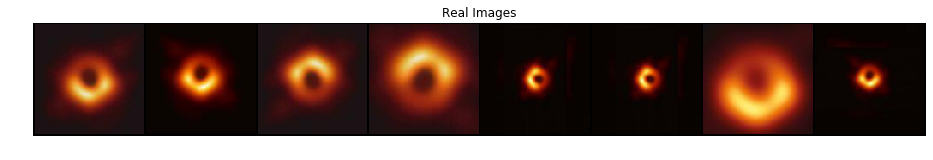

In [5]:
#decidde the device
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

#show some sample picturees
real_batch = next(iter(data_loader))
plt.figure(figsize=(16,16))
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:8], padding=2, normalize=True),(1,2,0)))

In [6]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [7]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            #out = (in-1)*stride - 2*padding + kernelsize + out_padding
            nn.ConvTranspose2d( nz, ngf * 16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),
            # state size. (ngf*16) x 4 x 4
            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 8 x 8
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 16 x 16
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 32 x 32
            nn.ConvTranspose2d(ngf * 2, ngf * 1, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ngf x 64 x 64
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 128x 128
        )

    def forward(self, input):
        return self.main(input)

In [8]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu >= 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchN

In [9]:
#Discriminator code

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 128 x 128
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # input is (ndf) x 64 x 64
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # input is (ndf*2) x 32 x 32
            nn.Conv2d(ndf*2, ndf * 4, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # input is (ndf*4) x 16 x 16
            nn.Conv2d(ndf*4, ndf * 8, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # input is (ndf*8) x 8 x 8
            nn.Conv2d(ndf*8, ndf * 16, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # input is (ndf*16) x 4 x 4
            nn.Conv2d(ndf * 16, 1, 4, 1, 0, bias=False),
        )

    def forward(self, input):
        return self.main(input)

In [10]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu >= 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Conv2d(1024, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
)


In [11]:
# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(8, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.RMSprop(netD.parameters(), lr=lr, alpha = 0.9)
optimizerG = optim.RMSprop(netG.parameters(), lr=lr, alpha = 0.9)

In [12]:
# use gradient penalty to realize W Distance
def calc_gradient_penalty(netD, real_data, fake_data, batch_size):
    alpha = torch.rand(batch_size, 1,1,1)
    alpha = alpha.expand(real_data.size())
    alpha = alpha.cuda() if (torch.cuda.is_available() and ngpu > 0) else alpha

    interpolates = alpha * real_data + ((1 - alpha) * fake_data)

    if torch.cuda.is_available() and ngpu > 0:
        interpolates = interpolates.cuda()
        
    interpolates = autograd.Variable(interpolates, requires_grad=True)

    disc_interpolates = netD(interpolates)

    gradients = autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                              grad_outputs=torch.ones(disc_interpolates.size()).cuda() if (torch.cuda.is_available() and ngpu > 0) else torch.ones(
                                  disc_interpolates.size()),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]

    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * 0.1
    return gradient_penalty


In [13]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
WD = []
iters = 0

one = torch.FloatTensor([1])
mone = one * -1

print("Starting Training Loop...")
# For each epoch
time_start = time.perf_counter()
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(data_loader, 0):
        ############################
        # (1) Update D network
        ###########################
        for p in netD.parameters():
                p.requires_grad = True
                
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_data = autograd.Variable(data[0])
        b_size = real_data.size(0)
        label = torch.full((b_size,), real_label, device=device)
        label = autograd.Variable(label)
        
        # train with real
        D_real = netD(real_data).view(-1)
        D_real = D_real.mean()
        D_real.backward(mone)

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = autograd.Variable(torch.randn(b_size, nz, 1, 1, device=device))
        # Generate fake image batch with G
        fake_data = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        D_fake = netD(fake_data).view(-1)
        D_fake = D_fake.mean()
        D_fake.backward(one)
        
        # train with gradient penalty
        gradient_penalty = calc_gradient_penalty(netD, real_data.data, fake_data.data, batch_size=batch_size)
        gradient_penalty.backward()

        D_cost = D_fake - D_real + gradient_penalty
        Wasserstein_D = D_real - D_fake
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        for p in netD.parameters():
                p.requires_grad = False
                
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        noise = autograd.Variable(torch.randn(b_size, nz, 1, 1, device=device))
        fake_data = netG(noise)
        G = netD(fake_data).view(-1)
        # Calculate G's loss based on this output
        G = G.mean()
        G.backward(mone)
        G_cost = -G
        optimizerG.step()

        # Output training stats
        if i % 2 == 0:
            print('[%d/%d][%d/%d]\tWasserstein_D: %.2f' %(epoch, num_epochs, i, len(data_loader),Wasserstein_D.item()))
           # print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
           #       % (epoch, num_epochs, i, len(data_loader),
           #          D_cost.item(), G_cost.item(), D_real, D_fake, G))
            

        # Save Losses for plotting later
        D_losses.append(D_cost.item())
        G_losses.append(G_cost.item())
        WD.append(Wasserstein_D.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 5 == 0) or ((epoch == num_epochs-1) and (i == len(data_loader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1
    time_epoch = time.perf_counter() - time_start
    seconds2HMS(time_epoch)

Starting Training Loop...
[0/40][0/4]	Wasserstein_D: -0.00
[0/40][2/4]	Wasserstein_D: 6.97
00:00:32
[1/40][0/4]	Wasserstein_D: 49.70
[1/40][2/4]	Wasserstein_D: 342.84
00:01:09
[2/40][0/4]	Wasserstein_D: 972.11
[2/40][2/4]	Wasserstein_D: 2194.04
00:01:41
[3/40][0/4]	Wasserstein_D: 4383.43
[3/40][2/4]	Wasserstein_D: 6022.79
00:02:14
[4/40][0/4]	Wasserstein_D: 10674.25
[4/40][2/4]	Wasserstein_D: 14736.59
00:02:46
[5/40][0/4]	Wasserstein_D: 19006.60
[5/40][2/4]	Wasserstein_D: 25768.31
00:03:17
[6/40][0/4]	Wasserstein_D: 34391.83
[6/40][2/4]	Wasserstein_D: 40335.41
00:03:49
[7/40][0/4]	Wasserstein_D: 29549.66
[7/40][2/4]	Wasserstein_D: 47161.66
00:04:21
[8/40][0/4]	Wasserstein_D: 56277.03
[8/40][2/4]	Wasserstein_D: 13837.06
00:04:56
[9/40][0/4]	Wasserstein_D: 48079.00
[9/40][2/4]	Wasserstein_D: 19343.00
00:05:39
[10/40][0/4]	Wasserstein_D: 37835.19
[10/40][2/4]	Wasserstein_D: 45118.00
00:06:23
[11/40][0/4]	Wasserstein_D: 41405.69
[11/40][2/4]	Wasserstein_D: 50322.50
00:06:55
[12/40][0/4]	Wa

In [14]:
torch.save(netG, './models/W_gen.pkl')
torch.save(netD, './models/W_Det.pkl')

C:\Users\haifei-zhang\Anaconda3\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Generator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\haifei-zhang\Anaconda3\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Discriminator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [15]:
np.save('./data/indicators/W_G_losses.npy',np.array(G_losses)) 
np.save('./data/indicators/W_D_losses.npy',np.array(D_losses)) 
np.save('./data/indicators/WD.npy',np.array(WD)) 
ims = [np.array(i) for i in img_list]
np.save('./data/indicators/W_img_list.npy',np.array(ims)) 

No handles with labels found to put in legend.


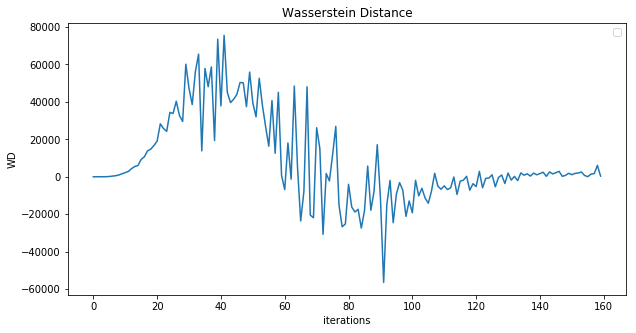

In [16]:
#result
#Loss versus training iteration
plt.figure(figsize=(10,5))
plt.title("Wasserstein Distance")
plt.plot(WD)
plt.xlabel("iterations")
plt.ylabel("WD")
plt.legend()
plt.show()

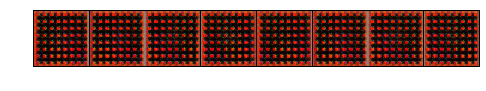

In [17]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

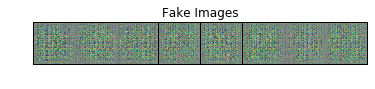

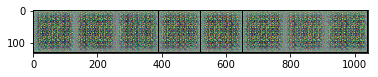

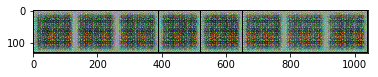

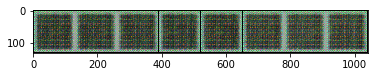

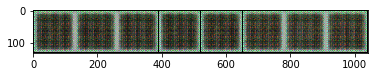

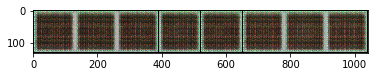

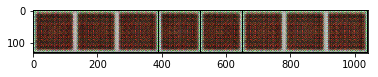

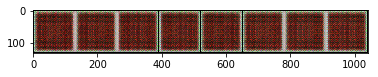

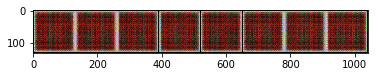

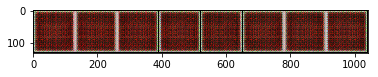

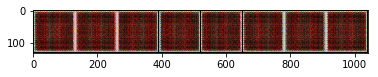

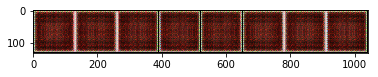

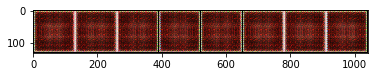

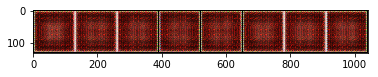

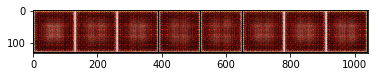

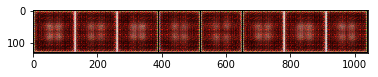

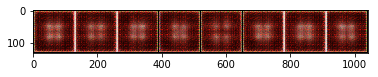

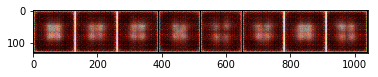

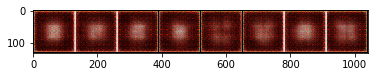

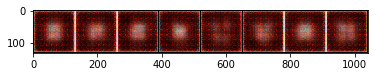

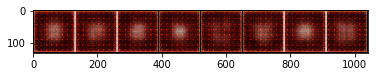

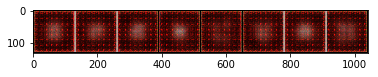

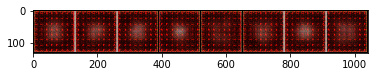

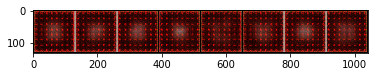

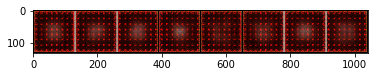

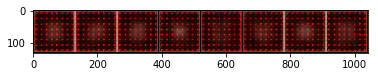

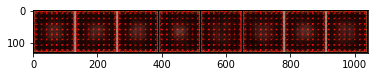

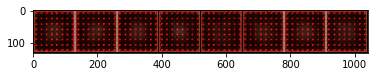

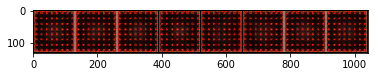

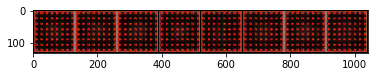

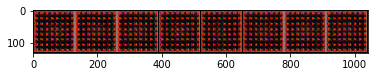

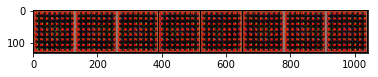

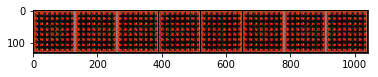

In [18]:
plt.axis("off")
plt.title("Fake Images")
for i in range(0,len(img_list)):   
    plt.imshow(np.transpose(img_list[i],(1,2,0)))
    plt.savefig("./data/images/WGAN_trous_noirs/pic{}.png".format(i))
    plt.show()

150 iterations get some things; after that, nothing